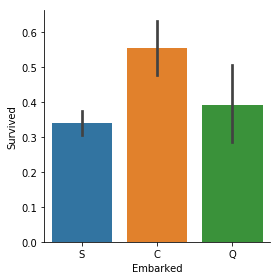

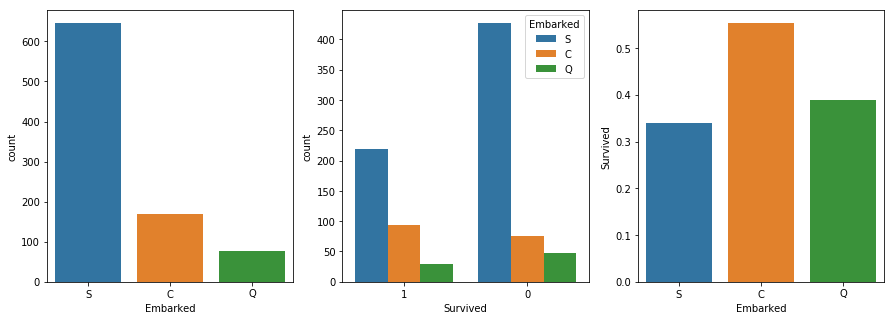

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

# Input data files are available in the "../input/" directory.
titanictrain_df=pd.read_csv("../input/train.csv")
titanictest_df=pd.read_csv("../input/test.csv")

#drop unnecessary features
titanictrain_df=titanictrain_df.drop(['PassengerId','Name','Ticket'],axis=1)

#Analysis of Individual Features
#Feature1: Embarked
#find the most occured value for Embarked to fill the missing values
titanictrain_df.groupby("Embarked").agg(["count","mean"])

#'S' has maximum count, fill the missing values with 'S'
titanictrain_df["Embarked"]=titanictrain_df["Embarked"].fillna("S")
titanictest_df=titanictest_df.drop(['Name','Ticket'],axis=1)

#plot
sns.factorplot('Embarked','Survived',data=titanictrain_df,kind="bar")
plt.show()

fig, (axis1, axis2, axis3) = plt.subplots(1,3,figsize=(15,5))
sns.countplot(x='Embarked',data=titanictrain_df,ax=axis1)
sns.countplot(x='Survived',hue="Embarked",data=titanictrain_df,order=[1,0],ax=axis2)
mean_df=titanictrain_df[["Embarked","Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked',y='Survived',data=mean_df,order=['S','C','Q'],ax=axis3)


embark_train_dummy=pd.get_dummies(titanictrain_df['Embarked'])
embark_train_dummy.drop(['S'],axis=1,inplace=True)
embark_test_dummy=pd.get_dummies(titanictest_df['Embarked'])
embark_test_dummy.drop(['S'],axis=1,inplace=True)

titanictrain_df=titanictrain_df.join(embark_train_dummy)
titanictest_df=titanictest_df.join(embark_test_dummy)

titanictrain_df.drop(['Embarked'],axis=1,inplace=True)
titanictest_df.drop(['Embarked'],axis=1,inplace=True)


In [2]:
#Feature2: Fare
for x in titanictest_df['Fare']:
    if pd.isnull(x):
        print("Null values")

titanictest_df["Fare"].fillna(titanictest_df["Fare"].median(),inplace=True)
#convert fare from float to int
titanictrain_df["Fare"]=titanictrain_df["Fare"].astype(int)
titanictest_df["Fare"]=titanictest_df["Fare"].astype(int)


Null values


In [3]:
#Feature 3: Age
#get average titanic, std titanic and count titanic null values
avg_titanic_train=titanictrain_df["Age"].mean()
std_titanic_train=titanictrain_df["Age"].std()
count_titanic_train=titanictrain_df["Age"].isnull().sum()

avg_titanic_test=titanictest_df["Age"].mean()
std_titanic_test=titanictest_df["Age"].std()
count_titanic_test=titanictest_df["Age"].isnull().sum()


#generate random number between mean and std deviation
rand_1=np.random.randint(avg_titanic_train-std_titanic_train,avg_titanic_train+std_titanic_train,size=count_titanic_train)
rand_2=np.random.randint(avg_titanic_test-std_titanic_test,avg_titanic_test+std_titanic_test,size=count_titanic_test)

titanictest_df["Age"][np.isnan(titanictest_df["Age"])]=rand_2
titanictrain_df["Age"][np.isnan(titanictrain_df["Age"])]=rand_1

titanictrain_df["Age"]=titanictrain_df["Age"].astype(int)
titanictest_df["Age"]=titanictest_df["Age"].astype(int)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
#Feature 4: Cabin

titanictest_df=titanictest_df.drop("Cabin",axis=1)
titanictrain_df=titanictrain_df.drop("Cabin",axis=1)

titanictrain_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q
0,0,3,male,22,1,0,7,0,0
1,1,1,female,38,1,0,71,1,0
2,1,3,female,26,0,0,7,0,0
3,1,1,female,35,1,0,53,0,0
4,0,3,male,35,0,0,8,0,0


In [5]:
#Feature 5: Family
# Instead of having two columns Parch & SibSp, 
# we can have only one column represent if the passenger had any family member aboard or not,
titanictrain_df["Family"]=titanictrain_df["SibSp"]+titanictrain_df["Parch"]
titanictrain_df["Family"].loc[titanictrain_df["Family"]>0]=1
titanictrain_df["Family"].loc[titanictrain_df["Family"]==0]=0

titanictest_df["Family"]=titanictest_df["SibSp"]+titanictest_df["Parch"]
titanictest_df["Family"].loc[titanictest_df["Family"]>0]=1
titanictest_df["Family"].loc[titanictest_df["Family"]==0]=0

titanictrain_df=titanictrain_df.drop(['SibSp','Parch'],axis=1)
titanictest_df=titanictest_df.drop(['SibSp','Parch'],axis=1)


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
#Feature 6: Sex

# As we see, children(age < ~16) on aboard seem to have a high chances for Survival.
# So, we can classify passengers as males, females, and child
def get_person(passenger):
  age,sex = passenger
  return 'child' if age < 16 else sex
    
titanictrain_df['Person'] = titanictrain_df[['Age','Sex']].apply(get_person,axis=1)
titanictest_df['Person']    = titanictest_df[['Age','Sex']].apply(get_person,axis=1)

titanictrain_df.drop(['Sex'],axis=1,inplace=True)
titanictest_df.drop(['Sex'],axis=1,inplace=True)

#remove male from person coz men are the least saved ones
person_dummy_train=pd.get_dummies(titanictrain_df['Person'])
person_dummy_train.columns=['Child','Female','Male']
person_dummy_train.drop(['Male'],axis=1,inplace=True)

person_dummy_test=pd.get_dummies(titanictest_df['Person'])
person_dummy_test.columns=['Child','Female','Male']
person_dummy_test.drop(['Male'],axis=1,inplace=True)

titanictrain_df=titanictrain_df.join(person_dummy_train)
titanictest_df=titanictest_df.join(person_dummy_test)
titanictrain_df.drop(['Person'],axis=1,inplace=True)
titanictest_df.drop(['Person'],axis=1,inplace=True)


KeyError: "['Sex'] not in index"

In [8]:
#Feature 7:  Pclass
#sns.factorplot('Pclass','Survived',order=[1,2,3], data=titanictrain_df,size=5)

# create dummy variables for Pclass column, & drop 3rd class as it has the lowest average of survived passengers
pclass_dummies_train = pd.get_dummies(titanictrain_df['Pclass'])
pclass_dummies_train.columns=['Class_1','Class_2','Class_3']
pclass_dummies_train.drop(['Class_3'],axis=1, inplace=True)

pclass_dummies_test = pd.get_dummies(titanictest_df['Pclass'])
pclass_dummies_test.columns=['Class_1','Class_2','Class_3']
pclass_dummies_test.drop(['Class_3'],axis=1, inplace=True)

titanictrain_df=titanictrain_df.join(pclass_dummies_train)
titanictest_df=titanictest_df.join(pclass_dummies_test)

titanictrain_df.drop(['Pclass'],axis=1,inplace=True)
titanictest_df.drop(['Pclass'],axis=1,inplace=True)

titanictrain_df.head()

,Survived,Age,Fare,C,Q,Family,Child,Female,Class_1,Class_2
0,0,22,7,0,0,1,0,0,0,0
1,1,38,71,1,0,1,0,1,1,0
2,1,26,7,0,0,0,0,1,0,0
3,1,35,53,0,0,1,0,1,1,0
4,0,35,8,0,0,0,0,0,0,0


In [10]:
#Define Training and Testing sets

X_Train = titanictrain_df.drop("Survived",axis=1)
Y_Train = titanictrain_df["Survived"]
X_Test = titanictest_df.drop("PassengerId",axis=1).copy()

In [11]:
#Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_Train, Y_Train)
Y_pred = logreg.predict(X_Test)
logreg.score(X_Train,Y_Train)


0.80808080808080807